In [109]:
import numpy as np
import qiskit as qk
from qiskit.circuit import QuantumCircuit, Parameter
import qutip as qt
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display

In [317]:
# Set up parameters of the Heisenberg Model
J=1.
Bx=1.
By=1.
Bz=1.
N=4
delta_t=0.05
tlist=np.arange(50)*delta_t

# Classical Simulation of the Heisenberg model

In the following we provide some code that utilizes `qutip` to solve this Schroedinger equation for the Trotterized simulation

In [111]:
def classically_simulate_Heisenberg_chain(N, J, Bx, By, Bz, psi0, tlist):
    '''
    This function takes in the following parameters
    N = Number of spins (Integer)
    Jx, Jy, Jz = Strength of Couplings (Floating point number)
    Bx, By, Bz = Strength of Magnetic field (Floating point number)
    psi0 = Initial state of the spin system
    tlist = List of times at which the wavefunction is calculated

    returns the expectation value of <sx(t)>,<sy(t)>,<sz(t)>
    '''
    si = qt.qeye(2)
    sx = qt.sigmax()
    sy = qt.sigmay()
    sz = qt.sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sy
        sy_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H +=  0.5 * Bx * sx_list[n]
        H +=  0.5 * By * sy_list[n]
        H +=  0.5 * Bz * sz_list[n]

    # interaction terms
    for n in range(N-1):
        H +=  0.5 * J * sx_list[n] * sx_list[n+1]
        H +=  0.5 * J * sy_list[n] * sy_list[n+1]
        H +=  0.5 * J * sz_list[n] * sz_list[n+1]


    # evolve and calculate expectation value of sz_list
    result = qt.mesolve(H, psi0, tlist, e_ops=sx_list+sy_list+sz_list)
    sx_expectval=(1/N)*np.sum(np.real(result.expect)[0:len(sx_list),:],0)
    sy_expectval=(1/N)*np.sum(np.real(result.expect)[len(sx_list):len(sx_list)+len(sy_list),:],0) 
    sz_expectval=(1/N)*np.sum(np.real(result.expect)[len(sx_list)+len(sy_list):len(sx_list)+len(sy_list)+len(sz_list),:],0)
    return sx_expectval,sy_expectval, sz_expectval

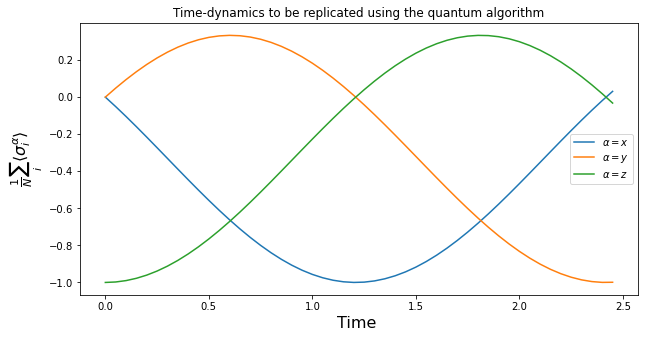

In [112]:
# intial state, all spins in state |+>=1/sqrt(2) (|0>+|1>)
psi0 = qt.tensor([qt.basis(2,1),qt.basis(2,1),qt.basis(2,1),qt.basis(2,1)]) # Tensor product the list to generate the initial state
sx_expt,sy_expt,sz_expt = classically_simulate_Heisenberg_chain(N, J, Bx, By, Bz, psi0, tlist)
plt.subplots(figsize=(10,5))
plt.plot(tlist, sx_expt,c='C0',label=r'$\alpha=x$')
plt.xlabel(r'Time ',fontsize=16)
plt.ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^\alpha_i \rangle$',fontsize=16)
plt.plot(tlist, sy_expt,c='C1',label=r'$\alpha=y$')
plt.plot(tlist, sz_expt,c='C2',label=r'$\alpha=z$')
plt.title('Time-dynamics to be replicated using the quantum algorithm')
plt.legend()

# Quantum Simulation of Heisenberg Chain

To simulate the dynamics using the Hamiltonian Simulation we need to do the following steps
1. Prepare the Initial State
2. Realize the decomposition of the $N$ qubit unitary in terms of one and two qubit gates
3. Reconstruct the desired observable from the measurments.

In [151]:
#Quantum computer parameters
backend = qk.Aer.get_backend('qasm_simulator')
num_shots=100000

## Prepare the initial state  [To Do]

Prepare an initial state that is the state $|1111\rangle$ and check that the circuit creates this state by performing measurements.

In [115]:
def create_initial_state(circ,qr):
    '''
    Create and return a circuit for  the initial state for the experiment.
    Here we would like to prepare the |1>|1>|1>|1> state.
    '''
    
    circ.x(qr)
    circ.barrier()
    return circ

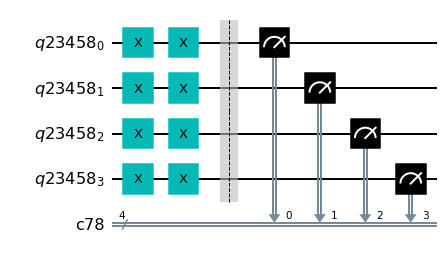

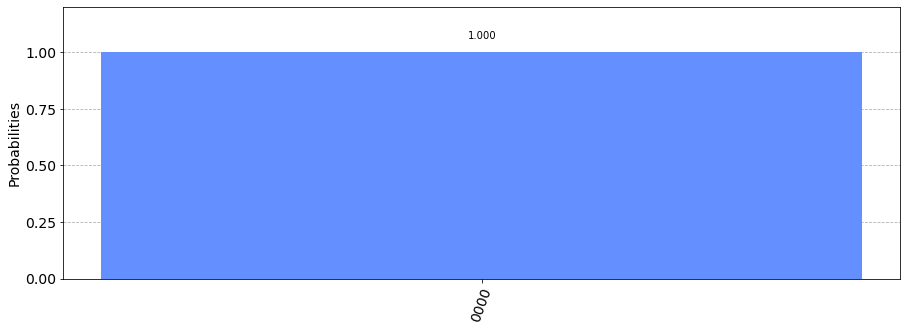

In [ ]:
# Test that the initial state created by the function is the |0101> state.
# Create a circuit and measure the output to make sure that this state is  |0101>
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ = qk.QuantumCircuit(qr,cr)
circ.x(qr)
temp = create_initial_state(circ,qr)
temp.measure(qr,cr)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=num_shots)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5)) #check that all states have nearly equal probability 1/16

## Creating the Unitary for two qubit interactions [To Do]
Next we look at creating two-qubit interactions as desired from the Hamiltonian. The interactions in the Ising model mean that  we are interested in realizing the following general two-qubit gate,

\begin{align}
U_{\rm Ising}=e^{-i\frac{\theta}{2}( \sigma^x\otimes \sigma^x+\sigma^y\otimes \sigma^y+\sigma^z\otimes \sigma^z)}
\end{align}

For the parameters chosen in this notebook, it becomes convenient to choose the Rxx gate provided by qiskit. In general we will have to transpile an arbitrary two qubit unitary to the native gate set.

In [357]:
def Rxyz(theta):
    '''
    Implements the Heisenberg interaction unitary gate.
    Returns a two-qubit circuit with the standard Rxyz(theta) gate applied between 0 and 1.
    '''
    circ=qk.QuantumCircuit(2)
    circ.rz(-np.pi/2,1)
    circ.cx(1,0)
    circ.rz((theta+np.pi/2),0)
    circ.ry((-np.pi/2-theta),1)
    circ.cx(0,1)
    circ.ry((theta+np.pi/2),1)
    circ.cx(1,0)
    circ.rz(np.pi/2,0)
    return circ

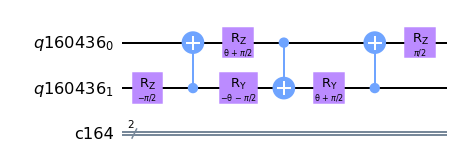

In [372]:
# test your Rxyz(theta) gate by printing out the circuit
theta=qk.circuit.Parameter('θ')
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ.compose(Rxyz(theta),qr1,inplace=True)
circ.draw('mpl')

### b) iii

Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j,  2.+0.j,  0.+0.j],
          [ 0.+0.j,  2.+0.j, -1.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


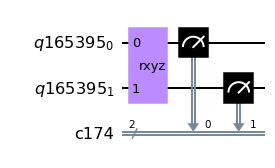

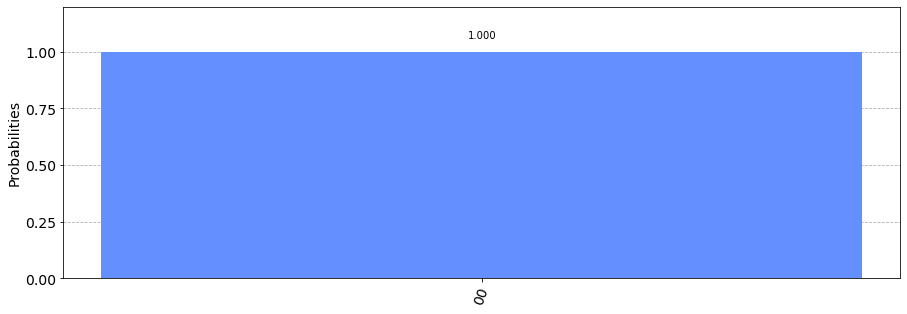

In [387]:
## baisis = 00
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import HamiltonianGate
XX = Operator(Pauli(label='XX'))
YY = Operator(Pauli(label='YY'))
ZZ = Operator(Pauli(label='ZZ'))
H_c = ZZ+YY+XX
print(H_c)
Unitary = HamiltonianGate(H_c,temp_num,label="rxyz")
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ.append(Unitary,qr1)
circ.measure(qr1,cr1)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=1000)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5))

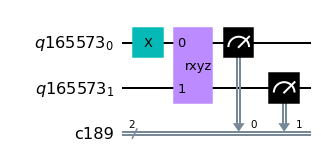

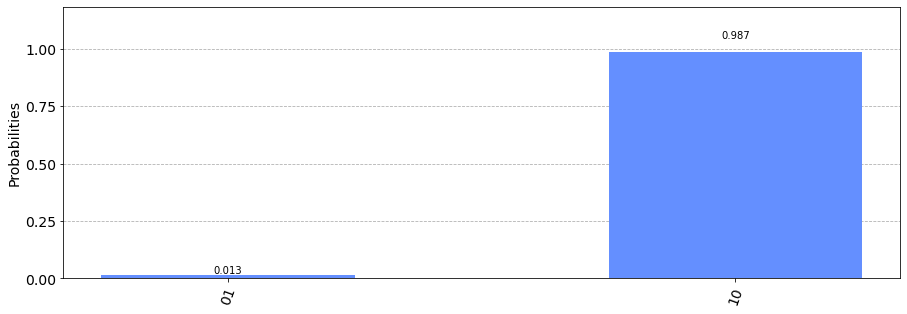

In [402]:
## baisis = 10
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ.x(0)
circ.append(Unitary,qr1)
circ.measure(qr1,cr1)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=1000)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5))

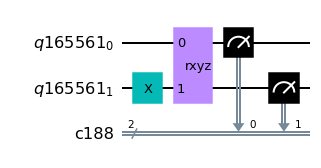

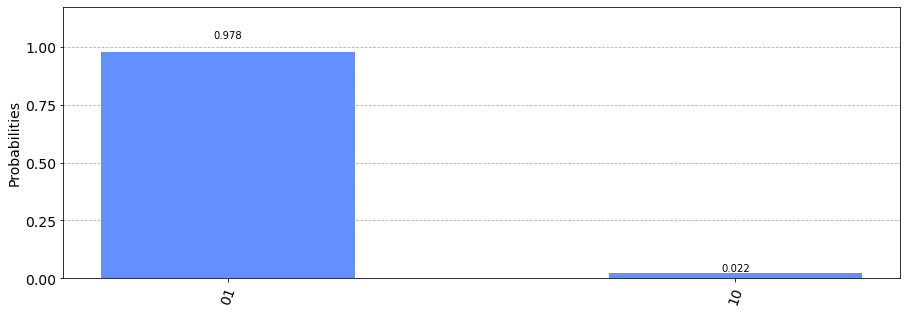

In [401]:
## baisis = 01
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ.x(1)
circ.append(Unitary,qr1)
circ.measure(qr1,cr1)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=1000)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5))

Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j,  2.+0.j,  0.+0.j],
          [ 0.+0.j,  2.+0.j, -1.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


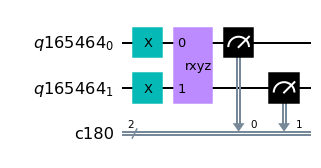

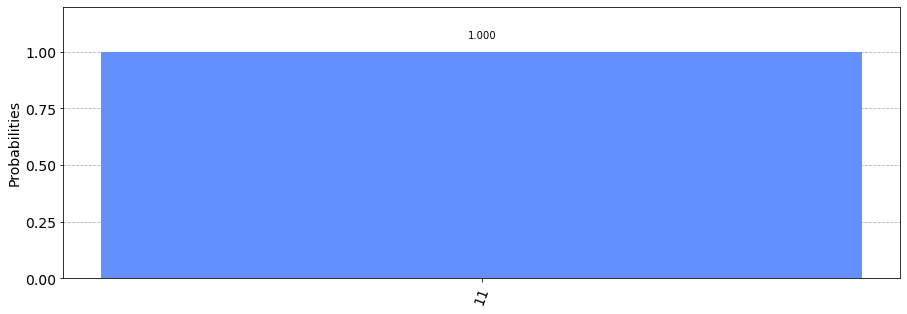

In [393]:
## baisis = 11
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ.x([0,1])
circ.append(Unitary,qr1)
circ.measure(qr1,cr1)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=1000)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5))

### b) iii with given circuit

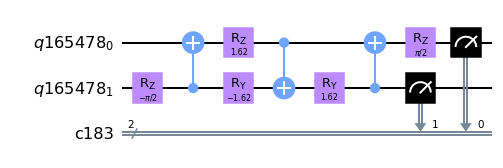

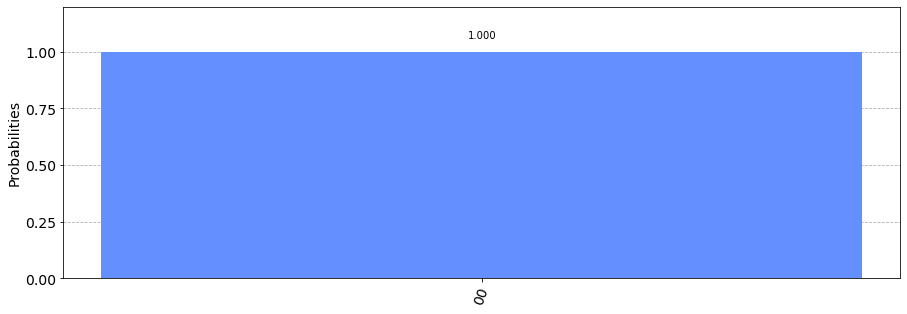

In [396]:
## baisis = 00
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ.compose(Rxyz(J*delta_t),[0,1], inplace=True)
circ.measure(qr1,cr1)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=1000)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5))

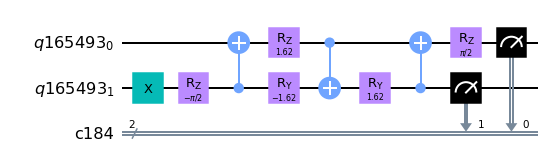

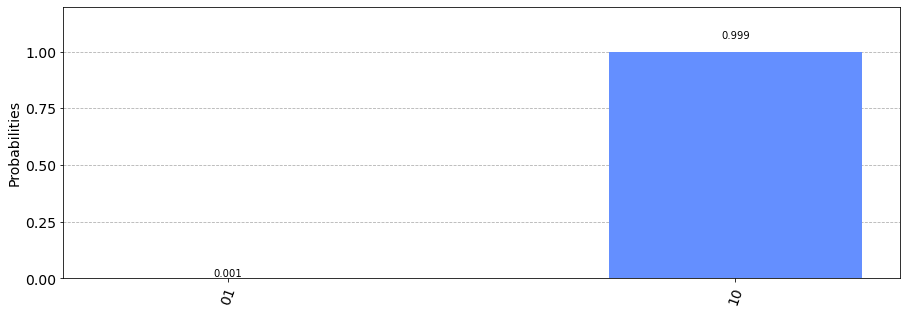

In [397]:
## baisis = 01
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ.x(1)
circ.compose(Rxyz(J*delta_t),[0,1], inplace=True)
circ.measure(qr1,cr1)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=1000)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5))

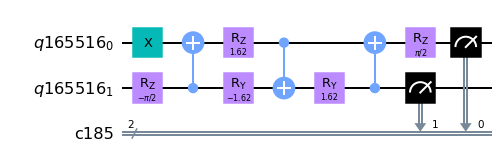

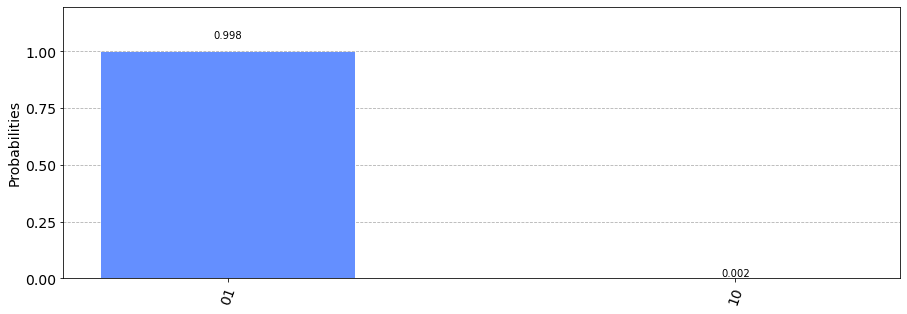

In [398]:
## baisis = 10
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ.x(0)
circ.compose(Rxyz(J*delta_t),[0,1], inplace=True)
circ.measure(qr1,cr1)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=1000)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5))

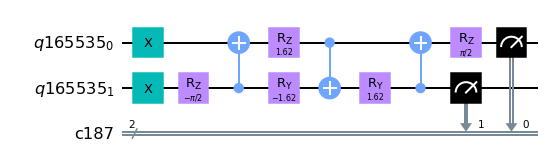

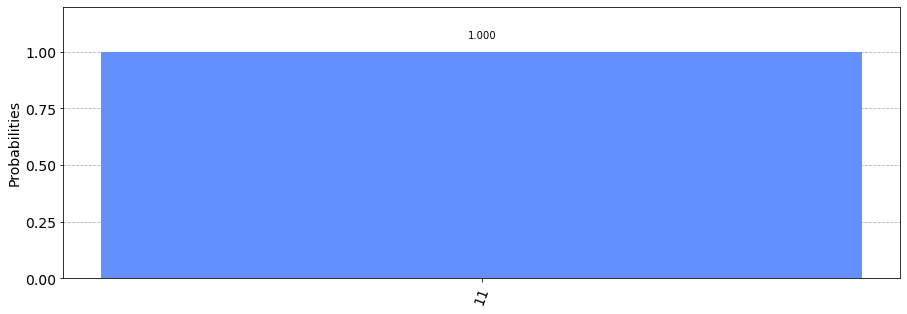

In [400]:
## baisis = 11
qr1=qk.QuantumRegister(2)
cr1=qk.ClassicalRegister(2)
circ = qk.QuantumCircuit(qr1, cr1)
circ.x([0,1])
circ.compose(Rxyz(J*delta_t),[0,1], inplace=True)
circ.measure(qr1,cr1)
display(circ.draw('mpl'))
job = qk.execute(circ, backend=backend,shots=1000)
result = job.result()
qk.visualization.plot_histogram(result.get_counts(),figsize=(15,5))

## Creating the Unitary for a single time-step 

Now we are ready to create the Unitary operator for the Heisenberg Hamiltonian by composing one and two qubit gates. 

### Unitary using First Order Product Formula

In [354]:
def first_order_PF_step(circ,delta_t,J,Bx,By,Bz):
    '''
    Applies a Unitary for a single time step U(Δt) using first-order trotter expansion to the input quantum circuit.
    input : circ is a quantum circuit
    output : circ-U(Δt)-
    '''
    if(delta_t == 0):
        return circ
    circ.compose(Rxyz(J*delta_t),[0,1], inplace=True)
    circ.compose(Rxyz(J*delta_t),[2,3], inplace=True)
    circ.barrier()
    circ.compose(Rxyz(J*delta_t),[1,2], inplace=True)
    circ.barrier()
    for i in range(4):
        circ.rx(Bx*delta_t,i)
        circ.ry(By*delta_t,i)
        circ.rz(Bz*delta_t,i)
    circ.barrier()
    return circ

def first_order_PF(circ,t,m,J,Bx,By,Bz):
    if m==0:
        return circ
    delta_t = t/m
    for i in range(m):
        circ= first_order_PF_step(circ,delta_t,J,Bx,By,Bz)
    return circ
    

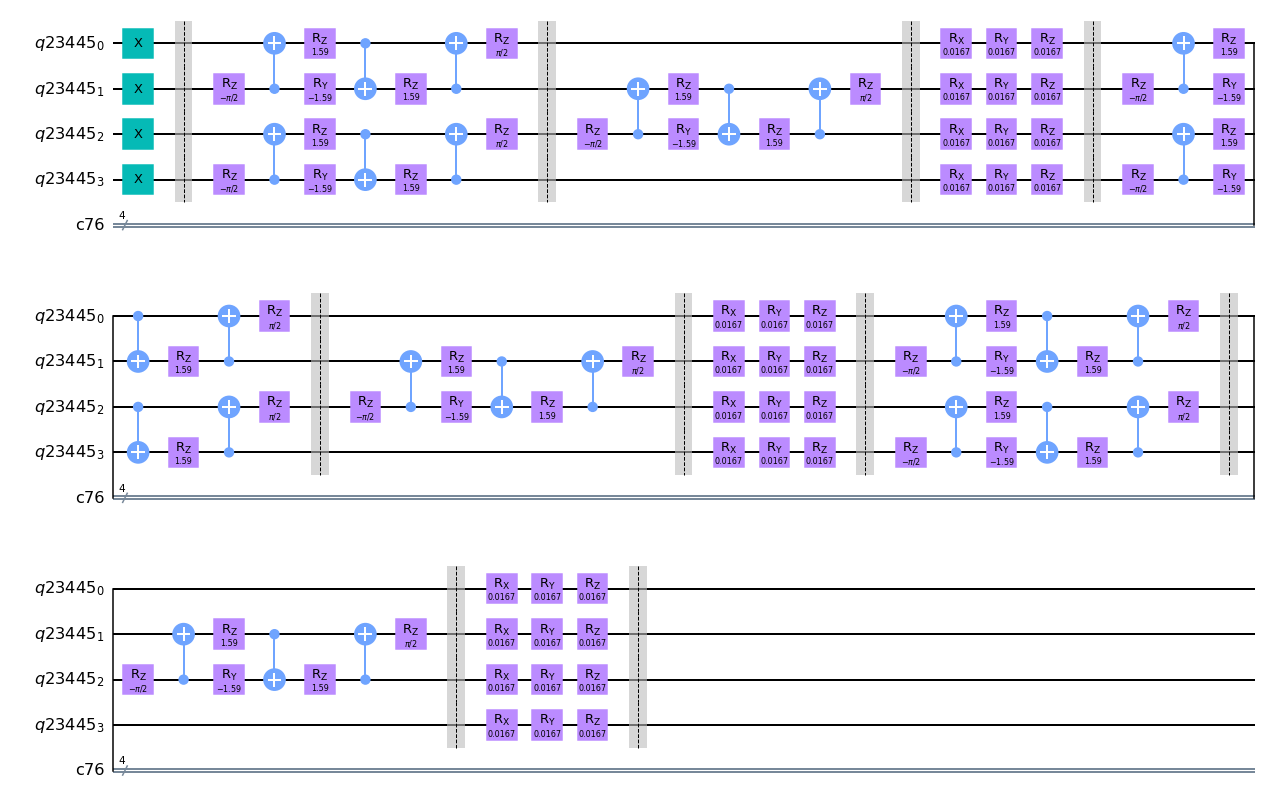

In [143]:
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ=qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ, qr)
circ=first_order_PF(circ,delta_t,3,J,Bx,By,Bz)
circ.draw('mpl')

## Measuring $m_x$, $m_y$ and $m_z$

Finally we need to measure expectation values from probabilities of measuring in particular basis states. 

In [338]:
def measure_m(basis_states,p_list):
    '''
    Takes input of probabilities for states for measurement in alpha={x or y or z} basis,
    and returns expectation value of <sigma_alpha> in that basis
    '''
    m_expectval=0
    for state,p in zip(basis_states,p_list):
        m_expectval+=p*(np.mean([(-1)**int(q) for q in state]))
    return (m_expectval)

def measurement_circuits(circ,qr,cr):
    
    circ_x=circ.copy()
    circ_x.name=circ_x.name+'-x'
    circ_x.h(qr)
    circ_x.measure(qr,cr)
    
    circ_y=circ.copy()
    circ_y.name=circ_y.name+'-y'
    circ_y.sdg(qr)
    circ_y.h(qr)
    circ_y.measure(qr,cr)
    
    circ_z=circ.copy()
    circ_z.name=circ_z.name+'-z'
    circ_z.measure(qr,cr)
    return [circ_x,circ_y,circ_z]
    

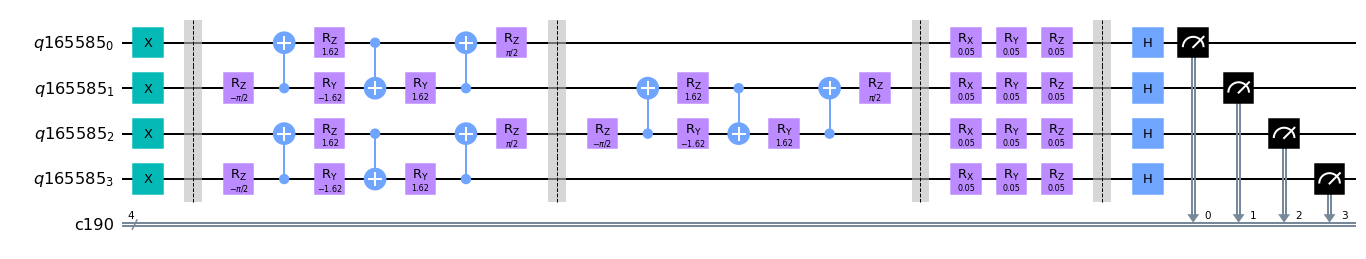

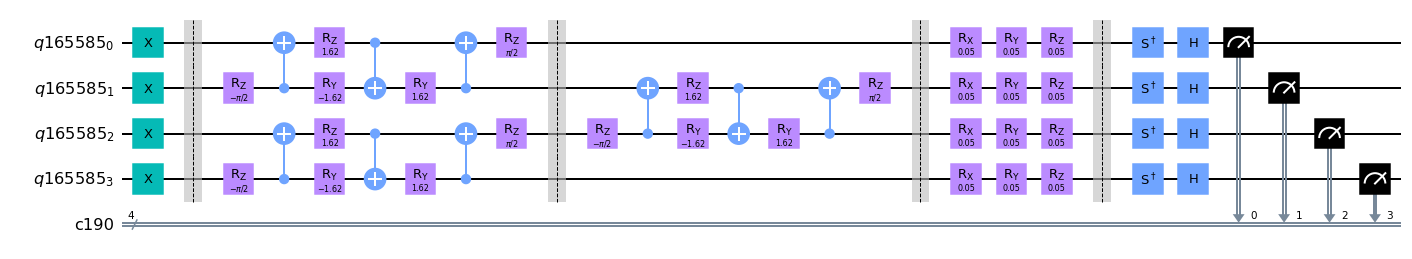

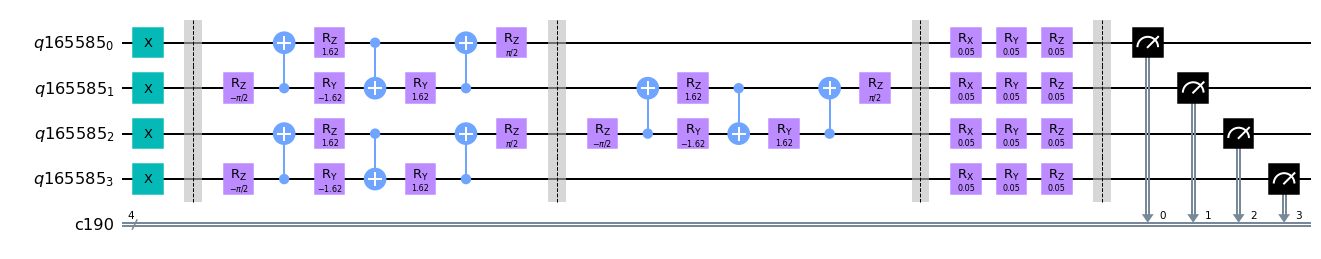

In [ ]:
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ=qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ,qr)
circ=first_order_PF_step(circ,delta_t,J,Bx,By,Bz)

circ_list=measurement_circuits(circ,qr,cr)
display(circ_list[0].draw('mpl',fold=-1))
display(circ_list[1].draw('mpl',fold=-1))
display(circ_list[2].draw('mpl',fold=-1))

## Bringing it all together to simulate the dynamics

Finally, let's bring together the state preparation, hamiltonian simulation and measurement to measure the required observable and compare with the classical simulation.

### First order Trotter Simulation

In [364]:
import time
import math
t = time.time()
num_shots= 1000000
temp_num = len(tlist)
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ=qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ,qr)
mx_list=[] # list of values containing mx
my_list=[] # list of values containing my
mz_list=[] # list of values containing mz
for p in range(temp_num):
    p_list = []
    basis_states = []
    if(p!=0):
        circ = first_order_PF_step(circ,delta_t,J,Bx,By,Bz)
    circ_list = measurement_circuits(circ,qr,cr)
    for i in range(3):
        job = qk.execute(circ_list[i], backend=backend,shots=num_shots)
        result = job.result()
        result_counts=result.get_counts()
        p_list.append([g/num_shots for g in result_counts.values()])
        basis_states.append(result_counts.keys())
    mx_list.append(measure_m(basis_states[0],p_list[0]))
    my_list.append(measure_m(basis_states[1],p_list[1]))
    mz_list.append(measure_m(basis_states[2],p_list[2]))
print('took ', math.trunc((time.time()-t)/60), "mins and ", (time.time() - t)-60*math.trunc((time.time() - t)/60), "secs")

took  18 mins and  0.5571503639221191 secs


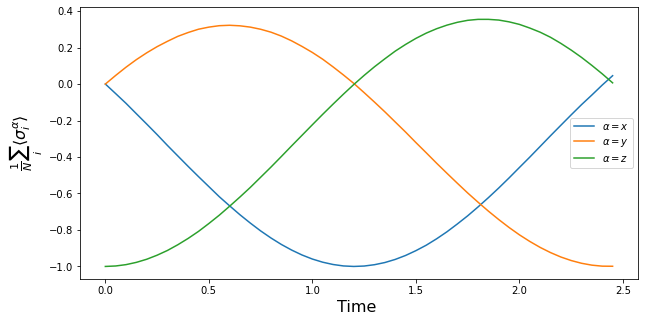

In [366]:
plt.subplots(figsize=(10,5))
plt.plot(tlist[0:temp_num], mx_list,c='C0',label=r'$\alpha=x$')
plt.xlabel(r'Time ',fontsize=16)
plt.ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^\alpha_i \rangle$',fontsize=16)
plt.plot(tlist[0:temp_num], my_list,c='C1',label=r'$\alpha=y$')
plt.plot(tlist[0:temp_num], mz_list,c='C2',label=r'$\alpha=z$')
plt.legend()      

### Doing another method for curiosity sake

In [374]:
import time
import math
t = time.time()
num_shots= 1000000
temp_num = len(tlist)
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ=qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ,qr)
mxc_list=[] # list of values containing mx
myc_list=[] # list of values containing my
mzc_list=[] # list of values containing mz
for p in range(temp_num):
    temp = circ.copy()
    p_list = []
    basis_states = []
    temp = first_order_PF_step(circ,tlist[p],J,Bx,By,Bz)
    #temp = first_order_PF(temp,tlist[p],1,J,Bx,By,Bz)
    #circ = first_order_PF_step(circ,delta_t,J,Bx,By,Bz)
    circ_list = measurement_circuits(temp,qr,cr)
    for i in range(3):
        job = qk.execute(circ_list[i], backend=backend,shots=num_shots)
        result = job.result()
        result_counts=result.get_counts()
        p_list.append([g/num_shots for g in result_counts.values()])
        basis_states.append(result_counts.keys())
    mxc_list.append(measure_m(basis_states[0],p_list[0]))
    myc_list.append(measure_m(basis_states[1],p_list[1]))
    mzc_list.append(measure_m(basis_states[2],p_list[2]))
print('took ', math.trunc((time.time()-t)/60), "mins and ", (time.time() - t)-60*math.trunc((time.time() - t)/60), "secs")

took  18 mins and  3.945856809616089 secs


#### Using regular Methods

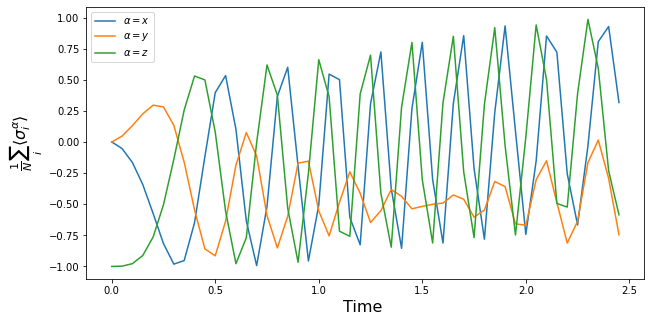

In [376]:
plt.subplots(figsize=(10,5))
plt.plot(tlist[0:temp_num], mxc_list,c='C0',label=r'$\alpha=x$')
plt.xlabel(r'Time ',fontsize=16)
plt.ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^\alpha_i \rangle$',fontsize=16)
plt.plot(tlist[0:temp_num], myc_list,c='C1',label=r'$\alpha=y$')
plt.plot(tlist[0:temp_num], mzc_list,c='C2',label=r'$\alpha=z$')
plt.legend()      

# Comparison between quantum simulation and classical simulation 

We compare the error in the quantum simulation as compared to exact classical simulation.

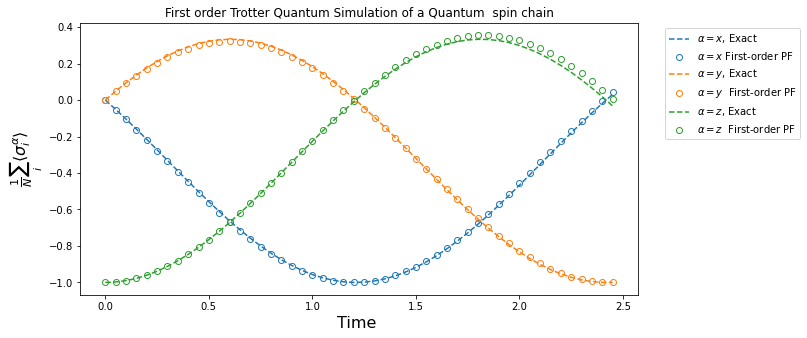

In [365]:
plt.subplots(figsize=(10,5))
plt.plot(tlist, sx_expt,'--',c='C0',label=r'$\alpha=x$, Exact')
plt.plot(tlist[0:temp_num], mx_list,'o',mfc='none',c='C0',label=r'$\alpha=x$ First-order PF')
plt.xlabel(r'Time ',fontsize=16)
plt.ylabel(r'$\frac{1}{N}\sum_i\langle \sigma^\alpha_i \rangle$',fontsize=16)
plt.plot(tlist, sy_expt,'--',c='C1',label=r'$\alpha=y$, Exact')
plt.plot(tlist[0:temp_num], my_list,'o',mfc='none',c='C1',label=r'$\alpha=y$  First-order PF')
plt.plot(tlist, sz_expt,'--',c='C2',label=r'$\alpha=z$, Exact')
plt.plot(tlist[0:temp_num], mz_list,'o',mfc='none',c='C2',label=r'$\alpha=z$  First-order PF')
plt.legend(bbox_to_anchor=(1.3,1.))   
plt.title(r'First order Trotter Quantum Simulation of a Quantum  spin chain');

# Error at a fixed time, $t$ as a function of $m$

In [367]:
t=1.
m_list=[10,20,30,40,50,60,70,80,90,100]
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ=qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ,qr)
mx_list2=[]
my_list2=[]
mz_list2=[]
for m in m_list:
    temp = circ.copy()
    p_list = []
    basis_states = []
    temp = first_order_PF(temp,t,m,J,Bx,By,Bz)
    #circ = first_order_PF_step(temp,delta_t,J,Bx,By,Bz)
    circ_list = measurement_circuits(temp,qr,cr)
    for i in range(3):
        job = qk.execute(circ_list[i], backend=backend,shots=num_shots)
        result = job.result()
        result_counts=result.get_counts()
        p_list.append([p/num_shots for p in result_counts.values()])
        basis_states.append(result_counts.keys())
    mx_list2.append(measure_m(basis_states[0],p_list[0]))
    my_list2.append(measure_m(basis_states[1],p_list[1]))
    mz_list2.append(measure_m(basis_states[2],p_list[2]))   

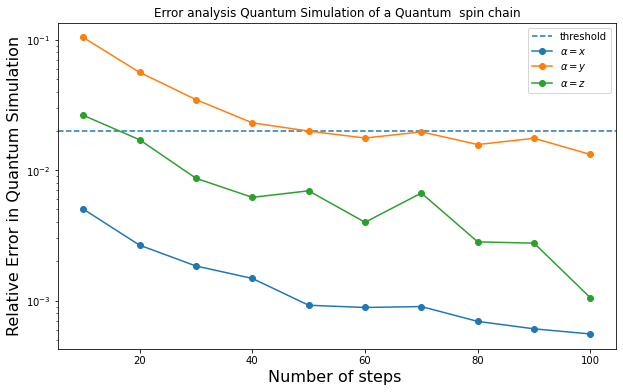

In [368]:
fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(0.02,ls='--',label='threshold')
ax.plot(m_list,np.abs((np.array(mx_list2) -(sx_expt[20]))/sx_expt[20]),'-o',c='C0',label=r'$\alpha=x$')
ax.plot(m_list,np.abs((np.array(my_list2) -(sy_expt[20]))/sy_expt[20]),'-o',c='C1',label=r'$\alpha=y$')
ax.plot(m_list,np.abs((np.array(mz_list2) -(sz_expt[20]))/sz_expt[20]),'-o',c='C2',label=r'$\alpha=z$')
ax.set_yscale('log')
ax.legend(loc=0)
ax.set_xlabel(r'Number of steps ',fontsize=16)
ax.set_ylabel(r'Relative Error in Quantum Simulation',fontsize=16)
ax.set_title(r'Error analysis Quantum Simulation of a Quantum  spin chain');

The total number of gates for below threshold measurment:

In [371]:
m= 50 # Fill this  # put in the smallest m to meet the criteria
qr = qk.QuantumRegister(N) # Define quantum register
cr = qk.ClassicalRegister(N) # Define classical register
circ=qk.QuantumCircuit(qr,cr)
circ = create_initial_state(circ,qr)
circ=first_order_PF(circ,t,m,J,Bx,By,Bz)
circ_measured=measurement_circuits(circ,qr,cr)
print(circ_measured[0].count_ops())
print(circ_measured[1].count_ops())
print(circ_measured[2].count_ops())

OrderedDict([('rz', 650), ('ry', 500), ('cx', 450), ('rx', 200), ('barrier', 151), ('x', 4), ('h', 4), ('measure', 4)])
OrderedDict([('rz', 650), ('ry', 500), ('cx', 450), ('rx', 200), ('barrier', 151), ('x', 4), ('sdg', 4), ('h', 4), ('measure', 4)])
OrderedDict([('rz', 650), ('ry', 500), ('cx', 450), ('rx', 200), ('barrier', 151), ('x', 4), ('measure', 4)])
